In [0]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# load data

In [0]:
%%time
df = pd.read_parquet('drive/My Drive/processed/tokenized_data.parquet')

In [0]:
np.save('doc_ids', df[1].values.astype(np.str))

In [0]:
!mv doc_ids.npy  'drive/My Drive/processed/'

In [0]:
doc_ids = np.load('drive/My Drive/processed/doc_ids.npy')

# load pretrained embeddings

In [0]:
in_npz = np.load('in.npz')
in_words = in_npz['words']
in_vectors = in_npz['vectors']
in_npz.close()

In [7]:
in_vectors.shape

(2748230, 200)

In [0]:
out_npz = np.load('out.npz')
out_words = out_npz['words']
out_vectors = out_npz['vectors']
out_npz.close()

In [9]:
out_vectors.shape

(2748230, 200)

In [10]:
np.all(in_words == out_words)

True

In [0]:
word2id = dict(zip(in_words, range(len(in_words))))

# Make doc vectors

In [0]:
def calc_doc_vec(words):
    ids = [word2id.get(x, -1) for x in words]
    word_vecs = in_vectors[ids]
    word_vecs /= np.linalg.norm(word_vecs)
    return word_vecs.mean(0)

In [0]:
doc_in_vectors = df[2].map(calc_doc_vec)

In [0]:
df[1]

0             0000107b869682826003b04a40e63948
1         00002df2-867b-11e1-abb4-839961045500
2             000045ed8eabe76d1049d21dfc08abbd
3             0000559e4f5786355e61755bd3bac097
4             000058a975a5d3bceec214776c48d7a2
                          ...                 
592336    1f20bc9c-66cf-11e4-9fdc-d43b053ecb4d
592337    1f20d3a4-5286-11e6-b7de-dfe509430c39
592338        1f21339277bc338e0d3982e74e19be90
592339        1f21411c2df92c17b34f5de64d007e06
592340    1f215b8e-55ce-11e7-b38e-35fd8e0c288f
Name: 1, Length: 592341, dtype: object

In [0]:
doc_in_vectors.index = df[1]

In [0]:
np.stack(doc_in_vectors.values).shape

(592341, 200)

In [0]:
np.save('doc_in_vectors', np.stack(doc_in_vectors.values))

In [0]:
!mv doc_in_vectors.npy "drive/My Drive/processed/"

In [0]:
word2id = dict(zip(out_words, range(len(out_words))))
def calc_doc_out_vec(words):
    ids = [word2id.get(x, -1) for x in words]
    word_vecs = out_vectors[ids]
    word_vecs /= np.linalg.norm(word_vecs)
    return word_vecs.mean(0)

In [0]:
%%time
doc_out_vectors = df[2].map(calc_doc_out_vec)

CPU times: user 25min 56s, sys: 55 s, total: 26min 51s
Wall time: 26min 51s


In [0]:
np.save('doc_out_vectors', np.stack(doc_out_vectors.values))

In [0]:
!mv doc_out_vectors.npy "drive/My Drive/processed/"

# Retrival

In [0]:
!ls "drive/My Drive/processed/"

doc_in_vectors.npy	   output.csv		  stemmed_data.parquet
doc_out_vectors.npy	   output.gsheet	  tokenized_data.parquet
document_judgments.csv	   output_stemmed.csv
document_judgments.gsheet  output_stemmed.gsheet


In [0]:
judgments_df = pd.read_csv("drive/My Drive/processed/document_judgments.csv", index_col=0)

In [0]:
doc_ids = np.load('drive/My Drive/processed/doc_ids.npy')

In [0]:
judgments_per_topic = pd.DataFrame(judgments_df.pivot(index='document_id', columns='topic_id', values='judgment'),
                                   index=doc_ids).fillna(0)

In [17]:
judgments_per_topic

topic_id,321,336,341,347,350,362,363,367,375,378,393,397,400,408,414,422,426,427,433,439,442,445,626,646,690,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825
0000107b869682826003b04a40e63948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00002df2-867b-11e1-abb4-839961045500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000045ed8eabe76d1049d21dfc08abbd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0000559e4f5786355e61755bd3bac097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000058a975a5d3bceec214776c48d7a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1f20bc9c-66cf-11e4-9fdc-d43b053ecb4d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1f20d3a4-5286-11e6-b7de-dfe509430c39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1f21339277bc338e0d3982e74e19be90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1f21411c2df92c17b34f5de64d007e06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
judgements_per_topic_selection = pd.DataFrame(judgments_df.pivot(index='document_id', columns='topic_id', values='judgment'),
                                   index=doc_ids)

In [0]:
judgements_per_topic_selection = judgments_per_topic.reset_index(drop=True)[
    (pd.DataFrame(judgments_df.pivot(index='document_id', columns='topic_id', values='judgment'),
                  index=doc_ids)
    # .reset_index().set_index('index', append=True)
    .notna().any(axis=1)
    ).values]

In [0]:
REL = np.sort(judgments_per_topic.values,axis=0)[::-1]

In [19]:
REL.shape

(592341, 50)

In [20]:
REL

array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [1., 2., 2., ..., 2., 2., 2.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
queries_df = judgments_df[['topic_id', 'title']].set_index('topic_id').drop_duplicates()

In [22]:
queries_df.head()

,title
topic_id,
321,Women in Parliaments
336,Black Bear Attacks
341,Airport Security
347,Wildlife Extinction
350,Health and Computer Terminals


In [0]:
queries_df['cleaned'] = queries_df.title.map(lambda x: 
    x.lower().replace(',','').replace('"','').replace('.','').replace('-',' ')
)

In [0]:
queries_df['ids'] = queries_df.cleaned.map(lambda s: [word2id[x] for x in s.split()])

In [0]:
queries_df['IN_vecs'] = queries_df.ids.map(in_vectors.__getitem__)
queries_df['OUT_vecs'] = queries_df.ids.map(out_vectors.__getitem__)

In [0]:
doc_vec_layers = {}
doc_vec_layers['IN'] =np.load("drive/My Drive/processed/doc_in_vectors.npy")
doc_vec_layers['OUT'] = np.load("drive/My Drive/processed/doc_out_vectors.npy")

In [0]:
def get_judge_order(judgemets_per_topic, queries_df, doc_vecs, query_layer_name='IN'):
    judge_order = []
    for topic_id, judgments in judgments_per_topic.iteritems():
        word_vecs = queries_df.at[topic_id, f'{query_layer_name}_vecs']
        similarities_per_word = np.dot(doc_vecs, word_vecs.T)
        similarities = similarities_per_word.mean(axis=1)
        doc_order = np.argsort(similarities)[::-1]
        judge_order.append(judgments.values[doc_order])
    return np.stack(judge_order)

In [0]:
pre_IDCG = (REL.T / np.log2(np.arange(1,REL.shape[0]+1)+1))

In [0]:
import itertools

In [0]:
from tqdm import tqdm

In [0]:
ranks = [1,2,3,4,5,10,50,100,500,1000,5000,
         10_000,50_000,100_000
         ]

In [34]:
scores = pd.DataFrame()
for query_layer_name, doc_layer_name in tqdm(itertools.product(['IN','OUT'],['IN','OUT']), total=4):
    judge_order = get_judge_order(judgments_per_topic, queries_df, doc_vec_layers[doc_layer_name], query_layer_name)
    pre_DCG = judge_order / np.log2(np.arange(1,judge_order.shape[1]+1)+1)
    for rank in ranks:
        DCG = pre_DCG[:,:rank].sum(axis=1).mean()
        IDCG = pre_IDCG[:,:rank].sum(axis=1).mean()
        NDCG = DCG/IDCG
        scores.loc[rank,f'{query_layer_name}_{doc_layer_name}'] = NDCG

100%|██████████| 4/4 [00:39<00:00,  9.94s/it]


In [35]:
scores

,IN_IN,IN_OUT,OUT_IN,OUT_OUT
1,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.001735,0.000000
5,0.000000,0.000000,0.004233,0.000000
10,0.000000,0.000746,0.005914,0.000000
50,0.000000,0.001331,0.003524,0.000000
100,0.000000,0.002619,0.003943,0.000000
500,0.000000,0.003025,0.007360,0.000000
1000,0.000000,0.004790,0.009597,0.000000


In [0]:
import matplotlib.pyplot as plt

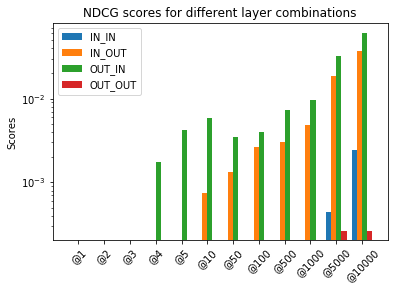

In [75]:
use_ranks = ranks[:-2]
labels = [f'@{rank}' for rank in use_ranks]

x = np.arange(len(labels))  
width = 0.20  

fig, ax = plt.subplots(figsize=(6,4))
for i, (colname, results) in enumerate(scores.iteritems()):
    ax.bar(x + i*width - width*1.5, results.loc[use_ranks], width, label=colname)

ax.set_ylabel('Scores')
ax.set_title('NDCG scores for different layer combinations')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_yscale('log')
ax.legend()

# fig.tight_layout()
plt.show()
fig.savefig("DESM.png", bbox_inches='tight', dpi=300)

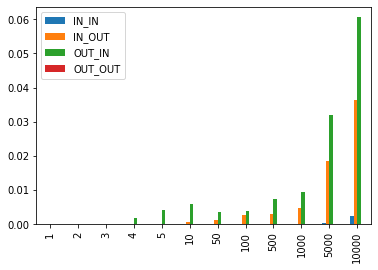

In [34]:
scores.loc[:10_000].plot.bar()

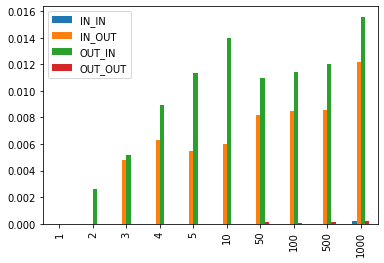

In [0]:
scores.loc[:1000].plot.bar()

# Preprocessing

## Joining judges and queries

In [0]:
topics_df = pd.read_csv("drive/My Drive/2018CommonCoreTrack/topics.csv", index_col=0)

In [0]:
topics_df.head()

,num,title,desc,narr
0,Number: 321,\nWomen in Parliaments \n,Description:\nPertinent documents will reflec...,Narrative\nPertinent documents relating to th...
1,Number: 336,\nBlack Bear Attacks \n,Description:\nA relevant document would discu...,Narrative\nIt has been reported that food or ...
2,Number: 341,\nAirport Security \n,Description:\nA relevant document would discu...,Narrative\nA relevant document would contain ...
3,Number: 347,\nWildlife Extinction \n,Description:\nThe spotted owl episode in Amer...,Narrative\nA relevant item will specify the c...
4,Number: 350,\nHealth and Computer Terminals \n,Description:\nIs it hazardous to the health o...,Narrative\nRelevant documents would contain a...


In [0]:
topics_df.num = topics_df.num.map(lambda x: int(x[len('Number:'):]))

In [0]:
topics_df.title = topics_df.title.map(str.strip)

In [0]:
topics_df.desc = topics_df.desc.map(lambda x: x[len("Description:\n"):].strip())
topics_df.narr = topics_df.narr.map(lambda x: x[len("Narrative\n"):].strip())

In [0]:
#queries_df = topics_df[['num', 'title']]

In [0]:
queries_df = judgments_df[['topic_id', 'document_id', 'judgment']].merge(topics_df[['num', 'title']], how='left', left_on='topic_id', right_on='num')

In [0]:
queries_df.to_csv('drive/My Drive/processed/document_judgments.csv')

In [0]:
# number of jugdged documents per query
queries_df.groupby('num')['judgment'].value_counts().to_frame().head(50)

judgment
num judgment          
321 0              570
    1               27
    2                2
336 0              488
    1                5
    2                3
341 0              357
    1               67
    2               57
347 0              393
    1               51
    2               30
350 0              575
    1               21
    2               10
362 0              484
    1               37
    2               35
363 0              535
    2              174
    1              153
367 0              406
    1               33
    2               12
375 0              445
    1               20
    2               10
378 0              440
    1               38
    2                9
393 0              462
    1               54
    2                6
397 0              424
    2              112
    1               76
400 0              452
    1               13
    2                5
408 0              476
    2              200
    1               36
414 0              461
    1                5
422 0              491
    2               76
    1               58
426 0              515
    1               54
    2               34

# CVS tokenized to Parquet

In [0]:
# chunk =  pd.read_csv("drive/My Drive/WashingtonPost.v2/data/tokenized_data.csv", header=None)

In [0]:
from tqdm import tqdm

import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd

In [0]:
for i, df in tqdm(enumerate(pd.read_csv("drive/My Drive/WashingtonPost.v2/data/tokenized_data.csv", chunksize=10_000, header=None)), total=60):
    # if 'e6b9576b2eb910f40a609335c3fdccf9' in df[1]:
    #     df = df[df[1] != 'e6b9576b2eb910f40a609335c3fdccf9']

    df[2] = df[2].map(lambda x: x[1:-1]).map(lambda x: [xi.strip()[1:-1] for xi in str.split(x, sep=',')])

    table = pa.Table.from_pandas(df)
    # for the first chunk of records
    if i == 0:
        # create a parquet write object giving it an output file
        pqwriter = pq.ParquetWriter('tokenized_data.parquet', table.schema)
        pqwriter.write_table(table)
    # subsequent chunks can be written to the same file
    else:
        pqwriter.write_table(table)
if pqwriter:
    pqwriter.close()

100%|██████████| 60/60 [03:54<00:00,  3.03s/it]


In [0]:
%%time
df = pd.read_parquet('tokenized_data.parquet')

CPU times: user 1min 32s, sys: 13.1 s, total: 1min 45s
Wall time: 1min 36s


In [0]:
!mv 'tokenized_data.parquet' 'drive/My Drive/processed/'

In [0]:
!ls -lh 'drive/My Drive/processed/'

total 1.6G
-rw-------  1 root root 1.9M Dec 17 08:05 document_judgments.csv
-rw-------+ 1 root root 1.6G Dec 17 10:08 tokenized_data.parquet


### Possible characters in embedded words

In [0]:
unique_chars = [set(w) for w in in_words]

In [0]:
char_set = set()

In [0]:
for word_chars in unique_chars:
    char_set.update(word_chars)

In [0]:
char_set

{'/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '<',
 '>',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [0]:
special_char_positions = np.array(['/' in w for w in in_words])

In [0]:
in_words[special_char_positions]

array(['</s>'], dtype='<U98')